In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# 1. Dataset Introduction & Loading

The dataset `physics_oscillation.csv` is a synthetic time series generated to simulate a damped oscillation. The data creation process is documented in `src/synthetic_data_generation.ipynb`.  

This dataset is intended to mimic the characteristics of real-world physical measurements. Such qualities introduce unique challenges for data-driven models, due to a lacking of the underlying physical context.

### Basic Information
- **Granularity:** 10 milliseconds
- **Length:** 600 records
- **Features:** Univariate, Physics, Labeled anomalies

## Loading the Dataset

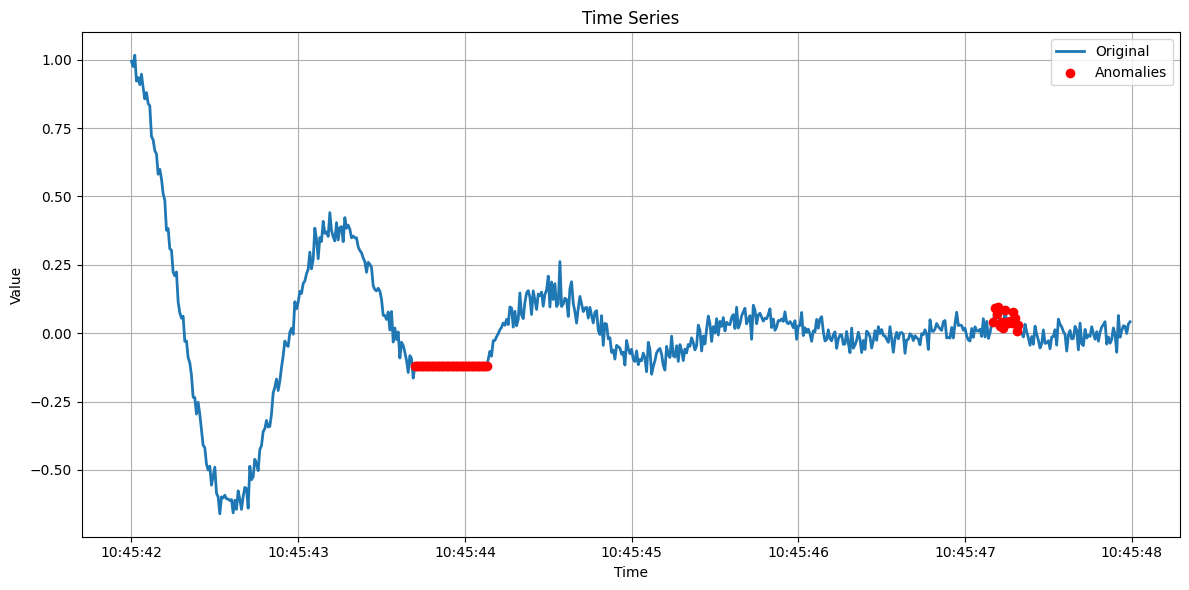

In [3]:
import pandas as pd
from src.synthetic_data.synthetic_data_tools import load_synthetic_data
from src.visualization.plots import plot_ts

data_file = '../data/physics_oscillation.csv'

data, ts, labels = load_synthetic_data(data_file, as_freq='10ms')
plot_ts(ts, anom=labels)

This dataset contains two sets of anomalies:  

- **Flat segment at `10:45:44`:** The time series briefly lies flat, which could represent a sensor malfunction, signal dropout, or an unexpected pause in the underlying system.  
- **Positive mean shift after `10:45:47`:** The oscillation baseline shifts upward, which could represent a change in external conditions (e.g., added external force, calibration drift, or environmental interference).  


# 2.  Classical Statistical Methods

## AR(2)

An **AR(2) model** is classic approach for modeling damped oscillations because it naturally captures the dynamics of sinusoidal patterns in discrete time. The model balances simplicity with effectiveness, reproducing oscillatory behavior while allowing for gradual decay in amplitude over time.

Mathematically, the AR(2) characteristic equation produces complex conjugate roots, which correspond to oscillatory behavior, while the magnitude of those roots controls the damping effect.

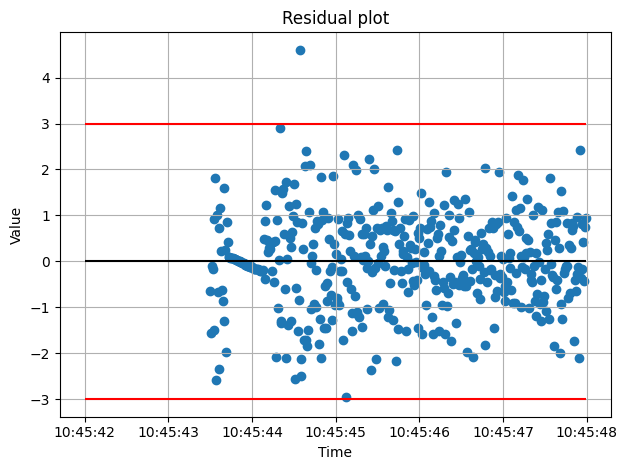

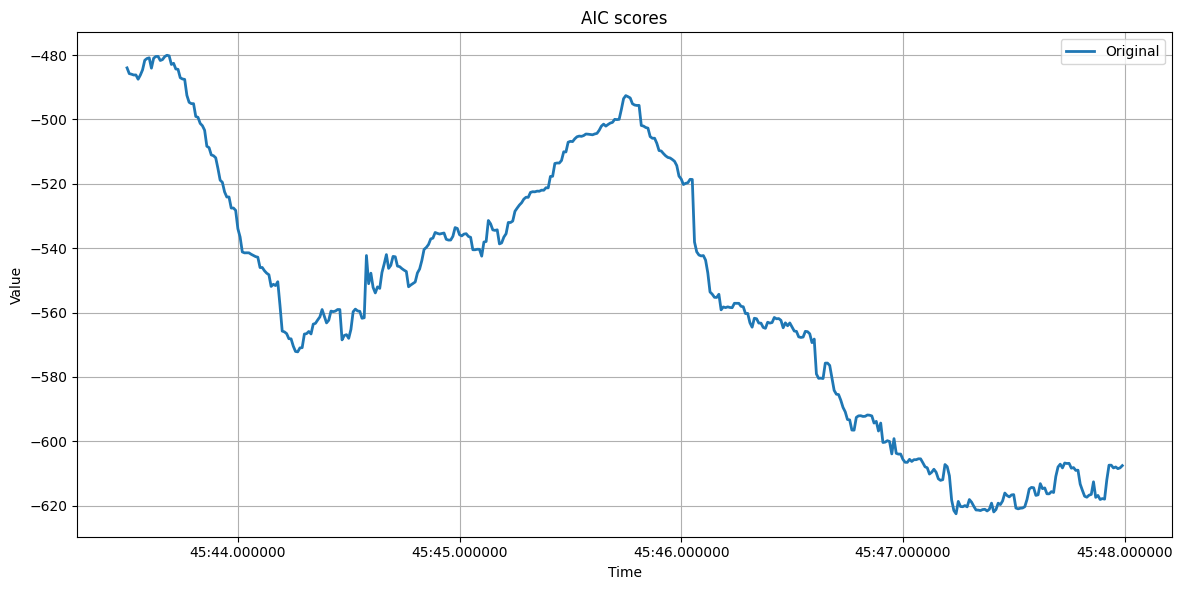

In [4]:
from src.models.preprocessing import create_sliding_windows, standardize_residuals
from statsmodels.tsa.ar_model import AutoReg
from src.visualization.plots import plot_scatter, plot_ts
import numpy as np

window_size = 150
windows = create_sliding_windows(ts, window_size=window_size)

residuals = np.full(len(ts), np.nan)  # store residuals
aic_scores = np.full(len(ts), np.nan)


for i, window in enumerate(windows):
    model = AutoReg(window, lags=2, old_names=False).fit()
    
    pred = model.predict(start=window_size, end=window_size)
    residuals[i+window_size] = ts.iloc[i+window_size] - pred[0]
    aic_scores[i+window_size] = model.aic

residuals = pd.Series(residuals, index=ts.index)
aic_scores = pd.Series(aic_scores, index=ts.index)
plot_scatter(standardize_residuals(residuals), hlines=[-3, 3])
plot_ts(aic_scores, title="AIC scores")

The residual plots show a strong correlation around `10:45:44`, aligning with the flat segment in the original time series. The only detected outlier occurs between `10:45:44` and `10:45:45`.  

Interestingly, the AIC scores peak at the start of the series and again near the end of `10:45:45`. Since neither of these points correspond to known anomalies, this suggests that AIC may not be a reliable indicator for detecting anomalies in rolling window model fits.


## Kalman Filters local level

Local level Kalman filters are effective for removing trends by separating a time series into a slowly varying level and random noise. This decomposition makes it easier to isolate short-term fluctuations, providing clean residuals for analysis.


c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


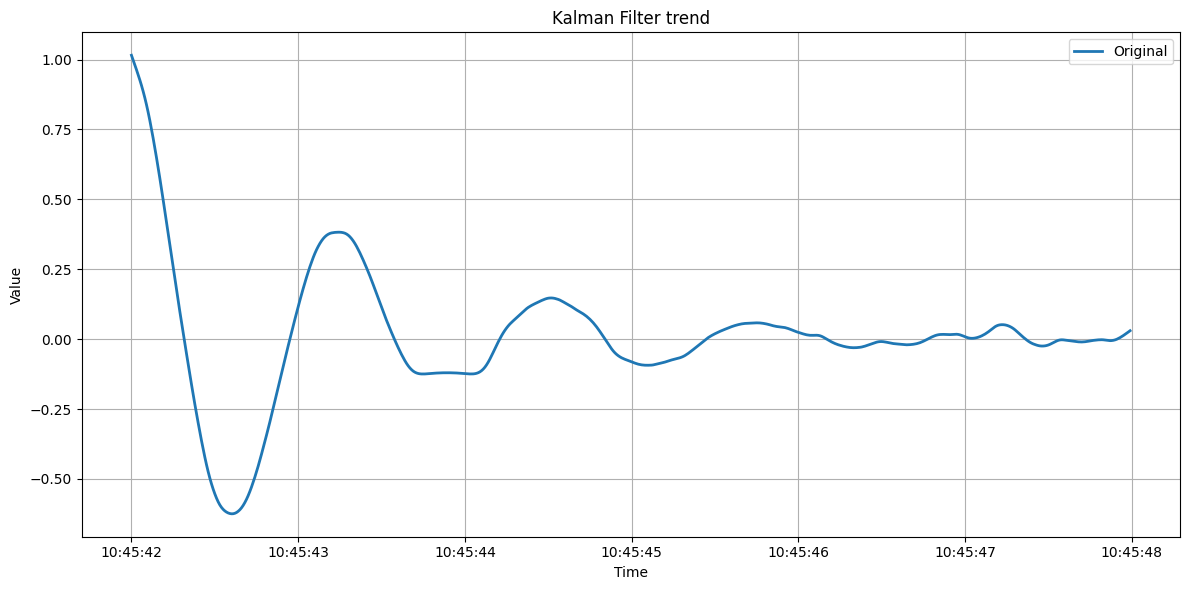

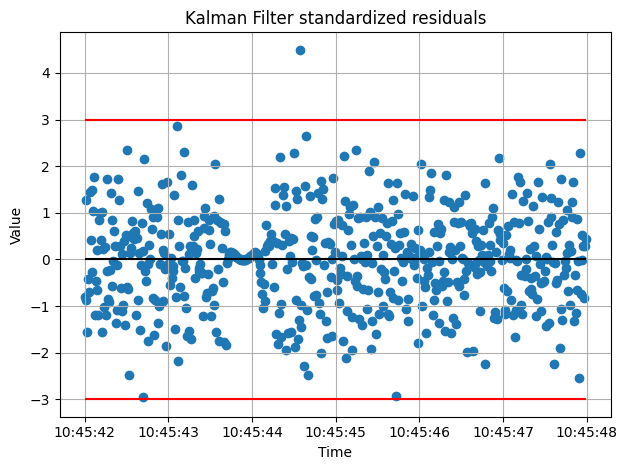

In [5]:
from src.models.statistical.kalman_filters import kalman_local_level
from src.visualization.plots import plot_ts, plot_scatter
from src.models.preprocessing import standardize_residuals

kalman_result = kalman_local_level(ts)
plot_ts(kalman_result['level'], title="Kalman Filter trend")
plot_scatter(standardize_residuals(kalman_result['resid']), hlines=[-3, 3], title="Kalman Filter standardized residuals")

The residual plots show a strong correlation around `10:45:44`, aligning with the flat segment in the original time series. The only detected outlier occurs between `10:45:44` and `10:45:45`.  

## Kalman Filter Cycle (Based on Physics formula)

Kalman filters become especially powerful when the **hidden states are defined** by the underlying **physical equations of the system**. Unlike many other models, they embed domain knowledge directly into the state-space representation, allowing the filter to track expected dynamics while still adapting to noise. In this sense, Kalman filters leverage both mathematical structure and data, offering an advantage over models that lack physical context.


c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


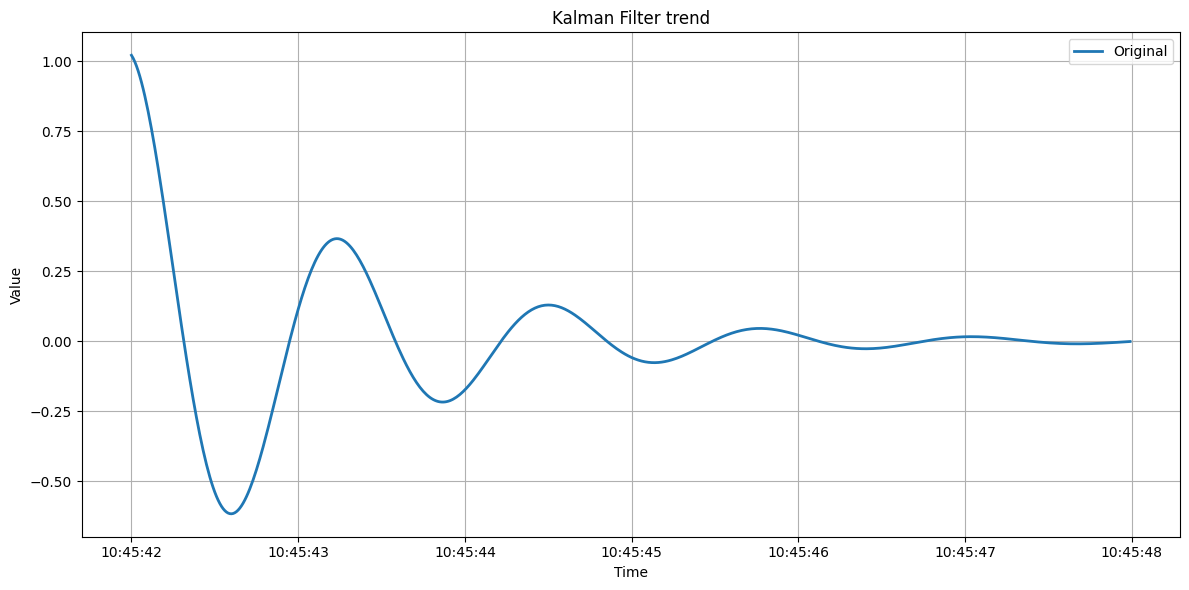

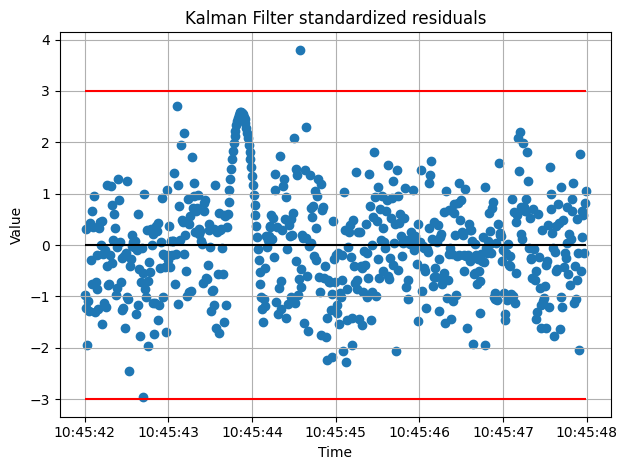

In [6]:
from src.models.statistical.kalman_filters import kalman_cycle

kalman_result = kalman_cycle(ts, period=125)
plot_ts(kalman_result['cycle'], title="Kalman Filter trend")
plot_scatter(standardize_residuals(kalman_result['resid']), hlines=[-3, 3], title="Kalman Filter standardized residuals")

In this case, the Kalman filter is fitted using hidden states based on the damped oscillation physics model. The extracted trend closely matches the ideal physical behavior, demonstrating the model’s ability to incorporate and reflect contextual knowledge.  

The residuals show a strong correlation around `10:45:44`, which corresponds to the flat segment in the original time series. This highlights how the residual analysis can reveal where the observed data deviates from the expected physical dynamics.

### CUSUM

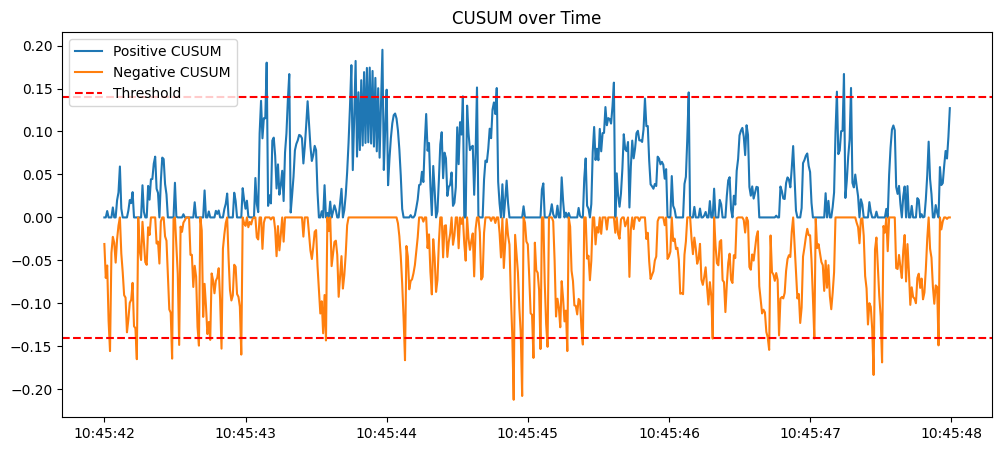

In [7]:
from src.models.statistical.rule_based import cusum

stl_cusum_anom = cusum(kalman_result['resid'], plot=True)

The CUSUM chart presents some shifts in residuals with the largest shifts around `10:45:44` and right before `10:45:45`. The mean of residuals is less stable during these times periods, suggesting a period of higher volatility and potential anomalies.

# 3 Self-trained Machine Learning models

## LSTM Auto-Encoder

A LSTM model with `window_size=125` (~1 oscillation) is fitted to the time series.

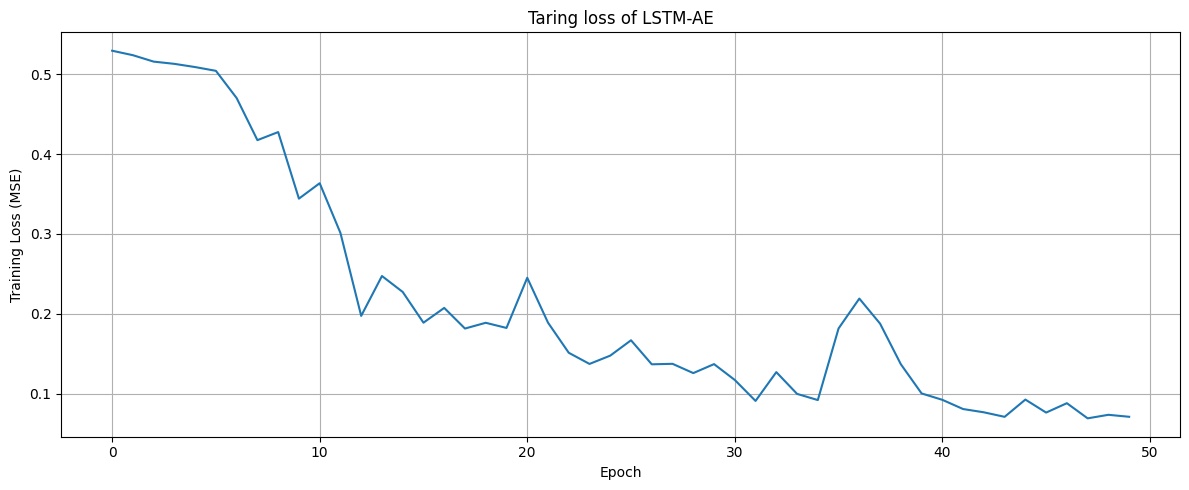

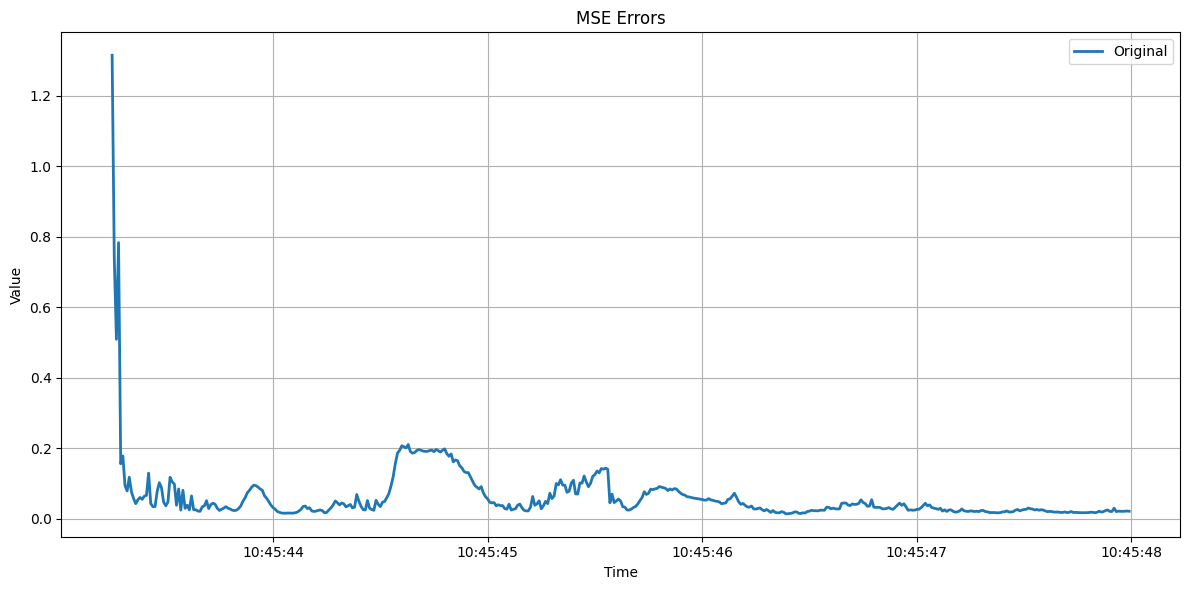

In [9]:
from src.models.self_trained_ml.lstm_ae import model_LSTMAE

mse_LSTM, _ = model_LSTMAE(ts, window_size=125, batch_size=16, hidden_dim=16, latent_dim=16, learning_rate=0.01, epochs=50, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[125:])
plot_ts(errors_ts, title='MSE Errors')

The training loss shows a steady downward trend without a clear elbow point, suggesting the model is not yet overfitting.  

The MSE values start high, then drop close to zero, with a small rise just before `10:45:45`—corresponding to the flat interval in the original time series. This indicates that the model is capturing the damped version of the oscillation (with small or near-zero amplitudes) rather than explicitly modeling the damping process. This behavior is expected, since LSTMs view only short, windowed segments of data without awareness of their order, making them naturally biased toward fitting the more frequent small-amplitude portions of the signal.


## Isolation Forest

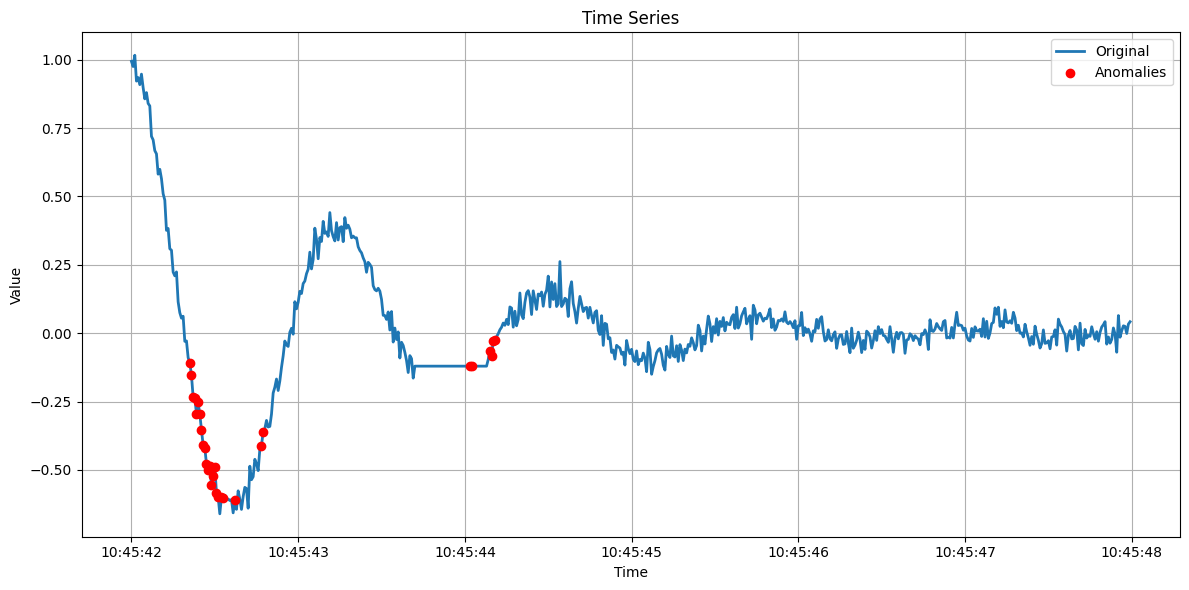

In [11]:
from src.models.self_trained_ml.isolation_forest import model_isolation_forest
import numpy as np

def extract_features(windows) -> pd.DataFrame:
    features = []
    for w in windows:
        w = pd.Series(np.ravel(w))
        f = {
            'mean': w.mean(),
            'std': w.std(),
            'min': w.min(),
            'max': w.max(),
            'skew': w.skew(),
            'kurt': w.kurt(),
            'slope': np.polyfit(np.arange(len(w)), w.values, 1)[0],
        }
        features.append(f)
    return pd.DataFrame(features)

if_results = model_isolation_forest(ts, extract_features=extract_features, window_size=35)
plot_ts(ts, anom=if_results['anomaly'])


Similarly to LSTMs, the anomalies identified by the Isolation forest cluster near the start of the time series. This shows that models working with unordered windowed data have no awareness of window order, making them naturally biased toward fitting the more frequent small-amplitude portions of the signal.

# 4 Pretrained Models

## Prophet

c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
14:12:54 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing


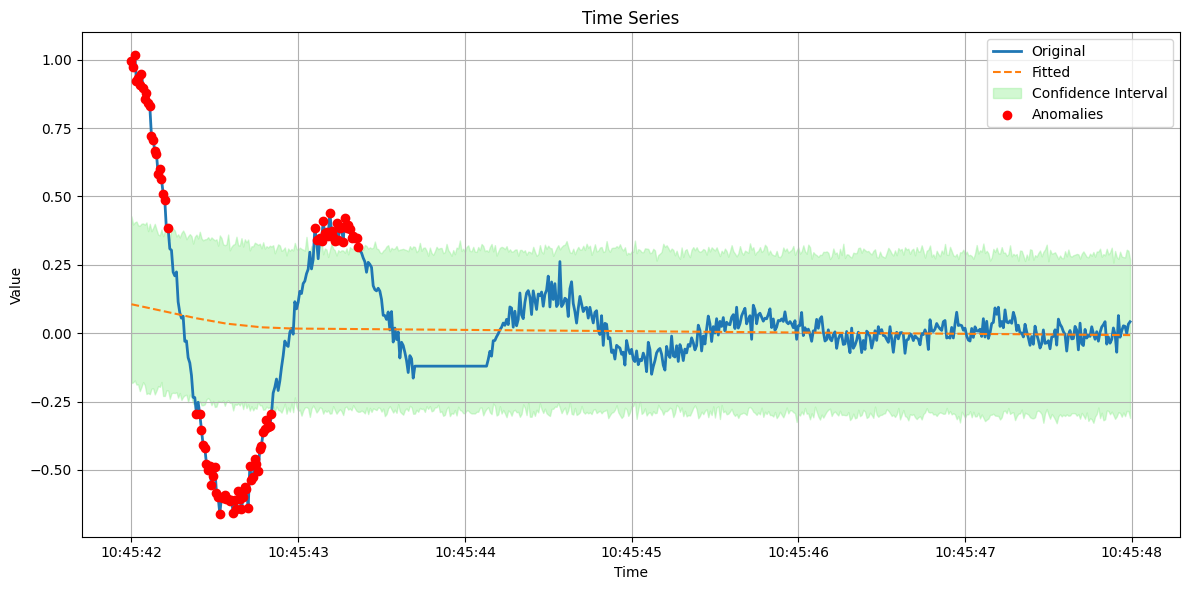

In [12]:
from prophet import Prophet
from src.visualization.plots import plot_ts

prophet_df = pd.DataFrame({
    'ds': ts.index,  
    'y': ts.values 
})

model = Prophet()
model.fit(prophet_df)

prophet_pred = model.predict(prophet_df[['ds']].copy())

prophet_anom = (prophet_df['y'] < prophet_pred['yhat_lower']) | (prophet_df['y'] > prophet_pred['yhat_upper'])
prophet_anom = pd.Series(prophet_anom.values, index=ts.index)

prophet_CI = prophet_pred[['yhat_lower', 'yhat_upper']].copy()
prophet_CI.index = ts.index

plot_ts(ts, pd.Series(prophet_pred['yhat'].values, index=ts.index), CI=prophet_CI, anom=prophet_anom)

Similarly to LSTMs and Isolation forest, Prophet fails to recognize the damp oscillation trend and marks early values in the time series as anomalies.

# 5 Summary & Comparisons 

None of the models tested above were perfect in identifying the exact anomalies in the `short_seasonal` dataset. Most models successfully flagged the unusual behavior during the flat segment of the time series, but **none** were able to detect the positive mean shift at the end. 

This outcome highlights both a limitation of the models but also a deeper question about interpretation: should a small shift in mean within noisy data always be considered an anomaly? In many real-world settings, such shifts may fall within natural variability, while in others they could signal meaningful changes in system behavior. 


|Model|Flat Segment Detected | False Positives|
|-------|-------------------------------|------------------|
|AR(2) + Z-scores| No | Sometimes |
|AR(2) + AIC| No | Yes |
|Kalman Filter Local level| Yes| Sometimes |
|Kalman Filter Cycle | Yes | Sometimes |
|LSTM-AE | Partially | Yes |
|Isolation forest| Partially | Yes |
|Prophet | No | Yes |